In [1]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('/kaggle/input/spam-ds/spam.csv')
data.head()


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
data['Spam']=data['Category'].apply(lambda x:1 if x=='spam' else 0)
data.head(5)

,Category,Message,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
data.shape


(5572, 3)

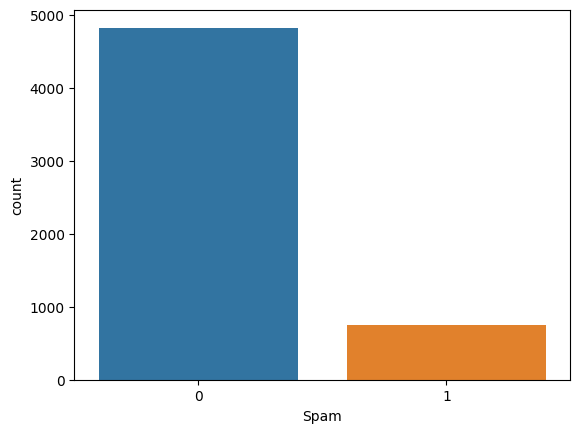

In [5]:
sns.countplot(x='Spam', data=data)
plt.show()


Text(0.5, 0, 'Message types')

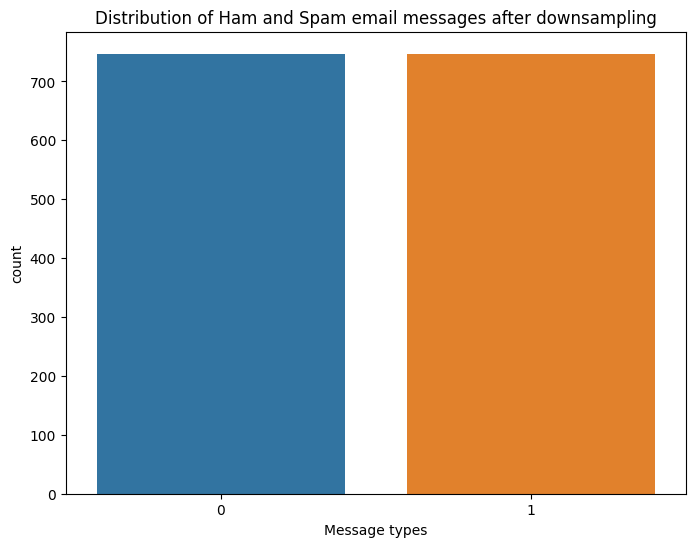

In [6]:
# Downsampling to balance the dataset
ham_msg = data[data.Spam == 0]
spam_msg = data[data.Spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),
						random_state=42)

# Plotting the counts of down sampled dataset
# Use pd.concat instead of append
balanced_data = pd.concat([ham_msg, spam_msg]).reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='Spam') # Changed 'spam' to 'Spam' to match column name
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [7]:
balanced_data['Message'] = balanced_data['Message'].str.replace('Subject', '')
balanced_data.head()


,Category,Message,Spam
0,ham,If i not meeting ü all rite then i'll go home ...,0
1,ham,"I.ll always be there, even if its just in spir...",0
2,ham,"Sorry that took so long, omw now",0
3,ham,I thk 50 shd be ok he said plus minus 10.. Did...,0
4,ham,Dunno i juz askin cos i got a card got 20% off...,0


In [8]:
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

balanced_data['Message']= balanced_data['Message'].apply(lambda x: remove_punctuations(x))
balanced_data.head()


,Category,Message,Spam
0,ham,If i not meeting ü all rite then ill go home l...,0
1,ham,Ill always be there even if its just in spirit...,0
2,ham,Sorry that took so long omw now,0
3,ham,I thk 50 shd be ok he said plus minus 10 Did ü...,0
4,ham,Dunno i juz askin cos i got a card got 20 off ...,0


In [9]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


balanced_data['Message'] = balanced_data['Message'].apply(lambda text: remove_stopwords(text))
balanced_data.head()


,Category,Message,Spam
0,ham,meeting ü rite ill go home lor ü dun feel like...,0
1,ham,ill always even spirit ill get bb soon trying ...,0
2,ham,sorry took long omw,0
3,ham,thk 50 shd ok said plus minus 10 ü leave line ...,0
4,ham,dunno juz askin cos got card got 20 4 salon ca...,0


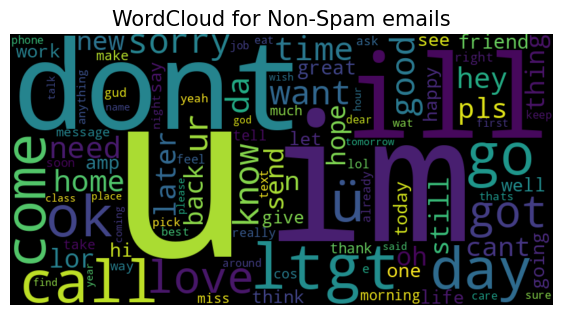

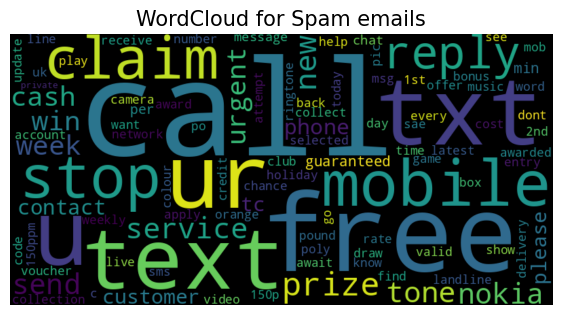

In [10]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['Message'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['Spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['Spam'] == 1], typ='Spam')


In [11]:
data.head()

,Category,Message,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [12]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['Message'],
													balanced_data['Spam'],
													test_size = 0.2,
													random_state = 42)


In [13]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len,
								padding='post',
								truncating='post')
test_sequences = pad_sequences(test_sequences,
							maxlen=max_len,
							padding='post',
							truncating='post')


In [14]:
# Model 1 - Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer # Import TfidfVectorizer

# Create a TfidfVectorizer to convert text to numerical features
vectorizer = TfidfVectorizer()
train_X_vec = vectorizer.fit_transform(train_X) # Fit and transform training data


# Create and train the RandomForestClassifier using the vectorized data
model1 = RandomForestClassifier()
model1.fit(train_X_vec,train_Y)

RandomForestClassifier()

In [15]:
test_X_vec = vectorizer.transform(test_X)


In [16]:
pred1 = model1.predict(test_X_vec)

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [18]:
print("Random Forest Classifier")
print("Confusion Matrix: ")
print(confusion_matrix(test_Y, pred1)) # Change Y_test to test_Y
print("Accuracy: ", accuracy_score(test_Y, pred1))
print("--------------------------------")

Random Forest Classifier
Confusion Matrix: 
[[140   5]
 [ 17 137]]
Accuracy:  0.9264214046822743
--------------------------------


In [19]:
with open("random_forest_model.pkl", "wb") as file:
    pickle.dump(model1, file)

NameError: name 'pickle' is not defined

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
text = "Hello Prajwal, you win a lottery of 1L"

# Transform the text using the same vectorizer used during training
X_new = vectorizer.transform([text])

# Make prediction
prediction = model1.predict(X_new)

# Output prediction
if prediction[0] == 1:
    print(True)
